In [152]:
import numpy as np
import random
import copy
import math
import matplotlib.pyplot as plt

In [153]:
def fitness(individual, items, capacity):
    total_value = 0
    total_weight = 0
    for i in range(len(individual)):
        if individual[i] == 1:
            total_value += items[i][0]
            total_weight += items[i][1]
    if total_weight <= capacity:
        return total_value
    return 0

In [181]:
def fitness_permutation(individual, items, capacity):
    total_value = 0
    total_weight = 0
    for i in individual:
        if total_weight + items[i][1] <= capacity:
            total_value += items[i][0]
            total_weight += items[i][1]
        else:
            break
    return total_value #- (capacity - total_weight)

In [182]:
def random_population(population_size, individual_size):
    population = [np.random.choice([0, 1], size=(individual_size,), p=[2/3, 1/3]) for _ in range(population_size)]
        
    return population

In [183]:
def random_population_permutation(population_size, individual_size):
    population = [np.random.permutation(individual_size) for _ in range(population_size)]
        
    return population

In [184]:
def read_data(filename: str) -> np.array:
    f = open(filename, "r")
    first_line = f.readline().split()
    item_amount = int(first_line[0])
    bag_capacity = int(first_line[1])

    pop = np.zeros((item_amount, 2), dtype=int)
    for i in range(item_amount):
        pop[i] = f.readline().split()

    return pop, bag_capacity

In [185]:
def two_point_crossover(parent_one, parent_two):
    first_point = random.randint(0, len(parent_one) - 2)
    second_point = random.randint(first_point, len(parent_one) - 1)

    child_one = np.concatenate((parent_one[:first_point], parent_two[first_point:second_point], parent_one[second_point:]))
    child_two = np.concatenate((parent_two[:first_point], parent_one[first_point:second_point], parent_two[second_point:]))
    return child_one, child_two

In [186]:
def PMX_one_offspring(p1, p2, cutoff_1, cutoff_2):
    offspring = np.zeros(len(p1), dtype=p1.dtype)

    # Copy the mapping section (middle) from parent1
    offspring[cutoff_1:cutoff_2] = p1[cutoff_1:cutoff_2]

    # copy the rest from parent2 (provided it's not already there
    for i in np.concatenate([np.arange(0,cutoff_1), np.arange(cutoff_2,len(p1))]):
        candidate = p2[i]
        while candidate in p1[cutoff_1:cutoff_2]: # allows for several successive mappings
            candidate = p2[np.where(p1 == candidate)[0][0]]
        offspring[i] = candidate
    return offspring

In [187]:
def two_point_crossover_permutation(parent_one, parent_two):
    first_point = random.randint(0, len(parent_one) - 2)
    second_point = random.randint(first_point, len(parent_one) - 1)

    child_one = PMX_one_offspring(parent_one, parent_two, first_point, second_point)
    child_two = PMX_one_offspring(parent_two, parent_one, first_point, second_point)
    return child_one, child_two

In [188]:
def mutation_switch(population,individual_mutation_prob=0.2,value_mutation_prob=0.1):
    new_population = []

    for j in range(0,len(population)):
        individual = copy.deepcopy(population[j])
        if random.random() < individual_mutation_prob:
            for i in range(0,len(individual)):
                if random.random() < value_mutation_prob:
                    if individual[i] == 1:
                        individual[i] = 0
                    else:
                        individual[i] = 1
        new_population.append(individual)
    return new_population

In [189]:
def mutation_switch_permutation(population,individual_mutation_prob=0.2,value_mutation_prob=0.1):
    new_population = []

    for j in range(0,len(population)):
        individual = copy.deepcopy(population[j])
        if random.random() < individual_mutation_prob:
            for i in range(0,len(individual)):
                if random.random() < value_mutation_prob:
                    individual[i], individual[(i+1)%len(individual)] = individual[(i+1)%len(individual)], individual[i]
        new_population.append(individual)
    return new_population

In [190]:
def selection(population,fitness_value): 
    new_population = []
    
    for i in range(0,int(np.ceil(len(population)/2))):

        first_idx = random.randint(0, len(population) -1)
        second_idx = random.randint(0, len(population) -1)

        third_idx = random.randint(0, len(population) -1)
        fourth_idx = random.randint(0, len(population) -1)

        first_parent, second_parent = None, None

        if fitness_value[first_idx] > fitness_value[second_idx]:
            first_parent = population[first_idx]
        else:
            first_parent = population[second_idx]

        if fitness_value[third_idx] > fitness_value[fourth_idx]:
            second_parent = population[third_idx]
        else:
            second_parent = population[fourth_idx]

        new_population.append([first_parent, second_parent])
    return new_population 

In [191]:
def evolution(data_filename: str, population_size: int, max_generations: int, ind_mut_prob: float, val_mut_prob: float):
    max_fitness = []
    items, bag_capacity = read_data(data_filename)
    population = random_population_permutation(population_size, len(items))
    
    for i in range(0,max_generations):
        fitness_value = [fitness_permutation(individual=individual, items=items, capacity=bag_capacity) for individual in population]
        max_fitness.append(max(fitness_value))
        parents = selection(population,fitness_value)
        children = np.array([[i for i in two_point_crossover_permutation(p[0], p[1])] for p in parents]).reshape(-1, len(items))
        mutated_children = mutation_switch_permutation(children, individual_mutation_prob=ind_mut_prob, value_mutation_prob=val_mut_prob)
        population = mutated_children
        
    # spocitame fitness i pro posledni populaci
    fitness_value = [fitness_permutation(individual=individual, items=items, capacity=bag_capacity) for individual in population]
    max_fitness.append(max(fitness_value))
    best_individual = population[np.argmax(fitness_value)]
    
    return best_individual, population, max_fitness, items, bag_capacity

best fitness:  295
best individual:  [8 9 7 3 2 1 6 0 4 5]


Text(0.5, 0, 'Generace')

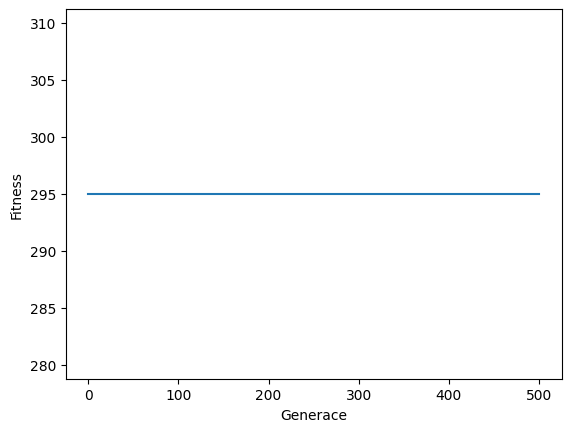

In [192]:
best, population, max_fitness, items, bag_capacity = evolution("data/debugging_data_10.txt" ,population_size=100, max_generations=500, ind_mut_prob=0.2, val_mut_prob=0.2)

print('best fitness: ', fitness_permutation(best, items, bag_capacity))
print('best individual: ', best)

plt.plot(max_fitness)
plt.ylabel('Fitness')
plt.xlabel('Generace')

best fitness:  1024
best individual:  [11  4  3 16  9 18 19  2 12  7 10  6  0  8 14  1  5 15 17 13]


Text(0.5, 0, 'Generace')

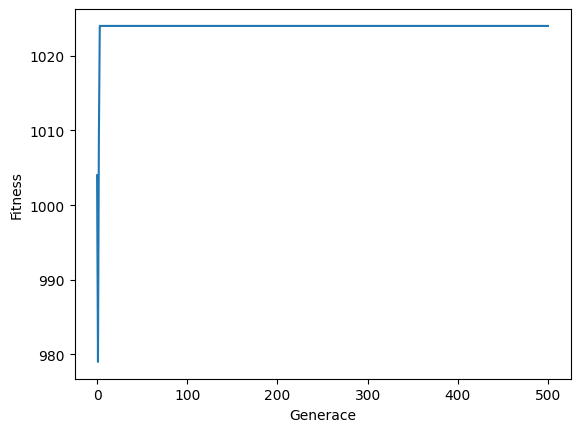

In [193]:
best, population, max_fitness, items, bag_capacity = evolution("data/debugging_data_20.txt" ,population_size=100, max_generations=500, ind_mut_prob=0.2, val_mut_prob=0.2)

print('best fitness: ', fitness_permutation(best, items, bag_capacity))
print('best individual: ', best)

plt.plot(max_fitness)
plt.ylabel('Fitness')
plt.xlabel('Generace')

best fitness:  9147
best individual:  [10 13 60 30 23 25 53  6 37 48 38 32 81 20 79 91 95 62 85 99 36  5 55  2
 41 40 50 56 51 74 71 49 98 58 92 63  4 12 46 45 54 88 35 73 78 11 29 21
 39  8 34 93 84 31 42 86 67  9 80 94 18 83 27 33 64  3 14 43 90  1 16 15
 17 82 57 26 72 69  7 75 68 19 77 59 24 97  0 96 44 28 61 65 22 76 66 52
 70 89 47 87]


Text(0.5, 0, 'Generace')

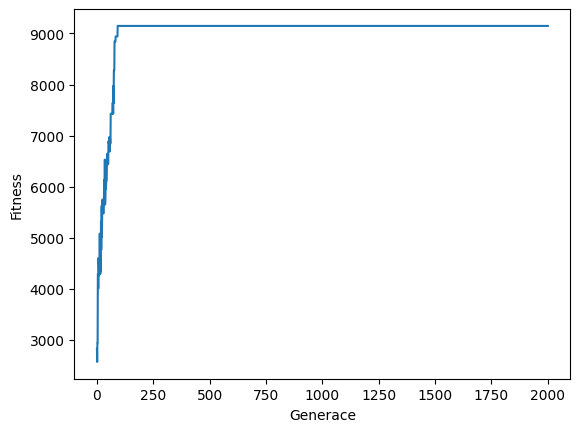

In [200]:
best, population, max_fitness, items, bag_capacity = evolution("data/input_data_100.txt" ,population_size=150, max_generations=2000, ind_mut_prob=0.15, val_mut_prob=0.25)

print('best fitness: ', fitness_permutation(best, items, bag_capacity))
print('best individual: ', best)

plt.plot(max_fitness)
plt.ylabel('Fitness')
plt.xlabel('Generace')

best fitness:  47634
best individual:  [419 281 987 770 967 986 603 657 373 362 273  38 824 948 914 134 494 215
 830 446 411 347 945 379 822  25 479 113  37  32 845 732 426 688 610 476
 382 703  13 697 669 493 886 737 599 146 573  48 855 743 216 786 643  60
 245 249 421 736 708 469 849 473  53 992 463  10 989 334 121 917  23 254
 519 878 981 618 804 608 803 388 801 764 974 226 761 726  18 478 730 220
 954 796 116 996 833 902 162 430 322 593  68 360 843 546 682 301 412 409
   4 753 327 385 168 155 712 462 607 952 512 641 182 485 390  20  42 799
 480  87 339 243 984 709 929 101 466 678 210 758 107 267 835 868 302 698
 393 129 238 236 869 897 585 642 312 193 365 516 705 315 235 942 324 751
 867 496 413 271 417 762 475 190 744 179 488 939 119 551 739 742 588  98
 928 432 285 320  40 675 720 614 531 990 403 969 629 276 681 353 142 487
 877 118 691 200  93 672 569 429 392 983 176 194 375 444  58 363  44 837
 231 953 440 620 836  15 637 181 740 102 893 410 227 565 900 755 132 465
 725 289 389

Text(0.5, 0, 'Generace')

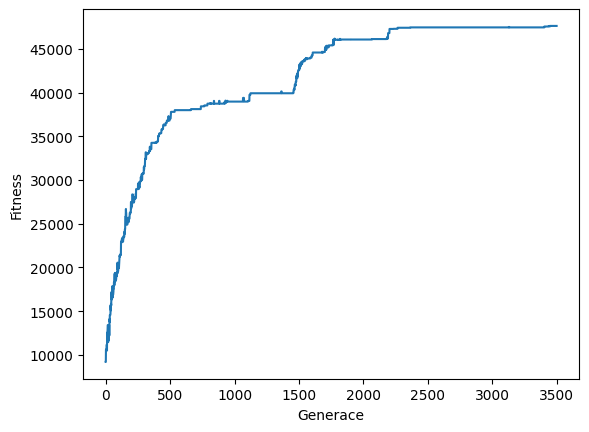

In [202]:
best, population, max_fitness, items, bag_capacity = evolution("data/input_data_1000.txt" ,population_size=150, max_generations=3500, ind_mut_prob=0.15, val_mut_prob=0.25)

print('best fitness: ', fitness_permutation(best, items, bag_capacity))
print('best individual: ', best)

plt.plot(max_fitness)
plt.ylabel('Fitness')
plt.xlabel('Generace')